In [296]:
import numpy
import scipy
import scipy.special
import scipy.stats
from sklearn import metrics
import matplotlib.pyplot as plt
import irp.pp, irp.map, irp.em
from irp.ndist import nexpon, ngamma
%load_ext ipython_unittest
%matplotlib inline

The ipython_unittest extension is already loaded. To reload it, use:
  %reload_ext ipython_unittest


# Intrusions in Marked Renewal Processes

This notebook is a part of empirical evaluation for the paper [](Intrusions in Marked Renewal Processes). 

## Helpers

We need an improper uniform distribution with pdf equal 1 everywhere. We will use it to ignore either marks or intervals for intrusion detection.

In [251]:
class ImproperUniform(object):
    """Improper uniform distribution.
    pdf, cdf, and sf is 1 everywhere.
    """
    def pdf(self, _):
        return 1
    
    def cdf(self, _):
        return 1
    
    def sf(self, _):
        return 1

## Evaluation on Synthetic data

Synthetic data are sampled from a marked renewal process of known shape and parameters. 

### Generative model

We first define a generative model for the data in Python. The model produces both normal entries and intrusions.

In [3]:
def generate(N, pi, F, G, Gi=nexpon(scale=1)):
    """
    Generates a data sequence with possible intrusion.
    Accepts:
        N - the number of events,
        F - interval distribution,
        G - mark distribution,
        Gi - intrusion mark distribution.
    Returns:
        [t_s, t_e, [[t_i, y_i] ...], [z_i ...]]
    where
        t_s - start of the interval
        t_e - end of the interval
        t_i - arrival time of the ith event
        y_i - mark of the ith event
        z_i - 1 if the event belongs to the intrusion, 0 otherwise.
    """
    # Normal events
    K = scipy.stats.binom.rvs(N, pi)
    ts = numpy.cumsum(F.rvs(size=N - K))
    ys = G.rvs(size=N - K)
    t_s = scipy.stats.uniform.rvs(0, ts[0])
    t_e = ts[-1] + t_s
    
    # Intrusion events
    ti_s, ti_e = scipy.stats.uniform.rvs(t_s, t_e - t_s, size=2)
    if ti_e < ti_s:
        ti_s, ti_e = ti_e, ti_s
    tis = scipy.stats.uniform.rvs(ti_s, ti_e - ti_s, size=K)
    yis = Gi.rvs(size=K)
    
    # Merge them into a single list
    SZ = [(t, s, 0) for t, s in zip(ts, ys)] + [(t, s, 1) for t, s in zip(tis, yis)]
    SZ.sort(key=lambda x: x[0])
    S = [(x, y) for x, y, _ in SZ]
    Z = [z for _, _, z in SZ]
    return [t_s, t_e, S, Z]

The event probability of belonging to an intrusion is chosen so that the probability of an intrusion is as given.

In [4]:
def get_pi(N, p=0.5):
    """"""
    return 1 - (1 - p)**(1. / N)

In [5]:
%%unittest
"""Check that generated data set is balanced as specified"""
for p in [0.25, 0.5, 0.75]:
    assert abs(scipy.stats.binom.pmf(0, 100, get_pi(100, p)) - (1 - p)) < 1E-6

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [6]:
%%unittest
"""check that traces contain intrusion with requested probability"""
N = 100
p = 0.5
pi = get_pi(N, p)
NITER = 1000
ind = 0
for i in range(NITER):
    t_s, t_e, S, Z = generate(N, pi, 
        F=scipy.stats.gamma(a=2, scale=1), 
        G=scipy.stats.expon(scale=1),
        Gi=scipy.stats.expon(scale=10))
    ind += any(Z)
assert abs(ind/NITER - p) < 0.05

Success

.
----------------------------------------------------------------------
Ran 1 test in 2.785s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Evaluation dataset

We can generate a data set using the generative model now. The data consists of tensors `T`, `S`, and `Z` containing intervals, samples and labels for the samples, correspondingly. We generate datasets for `p = 0.5` and `p = 0.995` of intrusion per trace. Both datasets are balanced.

In [105]:
NSAMPLES = 10000
FA = 4.
FSCALE = 1.
GSCALE = 1.
ISCALE = 2.
N = 20
ps = [0.0125, 0.025, 0.05, 0.1, 0.2]

def sfname(t, p):
    return format("../data/x-{}-synthetic-p={}.npy".format(t, p))

In [106]:
GENERATE = False # Change to True to regenerate the data set
if GENERATE:
    print("p")
    for p in ps:
        print("{:.4f}".format(p), end=" ")
        pi = get_pi(N, p)
        T = []
        S = []
        Z = []
        # We create a balanced data set here, otherwise
        # positive samples will be too sparse for realistic
        # values of P
        for i in range(NSAMPLES):
            while True:
                t_s, t_e, s, z = generate(N, pi, 
                    F=scipy.stats.gamma(a=FA, scale=FSCALE), 
                    G=scipy.stats.expon(scale=GSCALE),
                    Gi=scipy.stats.expon(scale=ISCALE))
                if (sum(z) == 0) == (numpy.random.rand() < p):
                    break
            T.append([t_s, t_e])
            S.append(s)
            Z.append(z)
        T = numpy.array(T)
        S = numpy.array(S)
        Z = numpy.array(Z)
        numpy.save(sfname("t", p), T, False)
        numpy.save(sfname("s", p), S, False)
        numpy.save(sfname("z", p), Z, False)
        print("✓")

p
0.0125 ✓
0.0250 ✓
0.0500 ✓
0.1000 ✓
0.2000 ✓


For analysis, we re-load the dataset. The dataset is a list of records, one record for each `p`.

In [107]:
DATASETS = []
SUBSIZE = None
for p in ps:
        T = numpy.load(sfname("t", p))
        S = numpy.load(sfname("s", p))
        Z = numpy.load(sfname("z", p))
        if SUBSIZE is not None:
            T = T[:SUBSIZE]
            S = S[:SUBSIZE]
            Z = Z[:SUBSIZE]
        DATASETS.append({"p": p,
                         "T": T,
                         "S": S,
                         "Z": Z})

With the dataset at hand, we are ready for the evaluation.

### Experiments with algorithms

#### Posterior Probabilities

In [324]:
def posteriors(ds, EM, F, G):
    pi = get_pi(ds["S"].shape[1], ds["p"])
    
    for mask in ["", "F", "G"]:
        P = numpy.ndarray(ds["S"].shape[0])
        M = numpy.ndarray(ds["S"].shape[:2])
        L = numpy.ndarray(M.shape)
        
        for i in range(ds["S"].shape[0]):
            print("{:>60} {:>5d}/{:<5d}\r".format(mask, i, ds["S"].shape[0]), flush=True, end="")
            S = ds["S"][i, :]
            t_s, t_e = ds["T"][i, :]

            if EM:
                F_, G_, _ = irp.em.parameters(t_s, t_e, S, pi)
            else:
                F_, G_ = F, G
            
            if mask == "F":
                F_ = ImproperUniform()
            elif mask == "G":
                G_ = ImproperUniform()

            P[i] = irp.pp.intrusion(t_s, t_e, S, pi, F_, G_)
            M[i, :] = irp.pp.marginal(t_s, t_e, S, pi, F_, G_)
            L[i, :] = irp.map.labels(t_s, t_e, S, pi, F_, G_)

        ds["P" + str(EM) + mask] = P
        ds["M" + str(EM) + mask] = M
        ds["L" + str(EM) + mask] = L
    print("{:>80}\r".format(""), end="")

Let's now compute posteriors for all samples in all data sets.

In [109]:
F = ngamma(a=FA, scale=FSCALE)
G = nexpon(scale=GSCALE)
print("EM\tp")
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{:.4f}".format(EM, ds["p"]), end=" ")
        posteriors(ds, EM, F, G)
        print("✓")

EM	p
False	0.0125 ✓
True	0.0125 ✓
False	0.0250 ✓
True	0.0250 ✓
False	0.0500 ✓
True	0.0500 ✓
False	0.1000 ✓
True	0.1000 ✓
False	0.2000 ✓
True	0.2000 ✓


Based on the computed results, we can obtain statistics on intrusion detection.

#### Basic analytics

First, we compute just the average intrusion probability in positive and negative samples. The greater the difference between these two numbers, the higher is the detection accuracy.

In [110]:
print("EM\tp\tnP\tpP\tnN\tpN")
ps = set()
curves = {}
for ds in DATASETS:
    for mask in ["", "F", "G"]:
        for EM in ["False", "True"]:
            pP = 0.
            pP2 = 0.
            pN = 0.
            pN2 = 0.
            nP = 0
            nN = 0
            for i in range(ds["S"].shape[0]):
                if sum(ds["Z"][i, :]) > 0:
                    pi = ds["P" + EM + mask][i]
                    pP += pi
                    pP2 += pi * pi
                    nP += 1
                else:
                    pi = ds["P" + EM + mask][i]
                    pN += pi
                    pN2 += pi * pi
                    nN += 1
            pP /= max(nP, 1)
            pN /= max(nN, 1)
            pP2 /= max(nP, 1)
            pN2 /= max(nN, 1)
            ps.add(ds["p"])
            if (EM + mask) not in curves:
                curves[EM + mask]  = {}
            curves[EM + mask][ds["p"]] = [pP, pN,
                                   numpy.sqrt(pP2 - pP * pP),
                                   numpy.sqrt(pN2 - pN * pN)]
            print("{}\t{:.4f}\t{:d}\t{:.4f}\t{:d}\t{:.4f}"
                  .format(EM, ds["p"], nP, pP, nN, pN))
ps = sorted(list(ps))

EM	p	nP	pP	nN	pN
False	0.0125	496	0.1561	504	0.0223
True	0.0125	496	0.0459	504	0.0157
False	0.0125	496	0.0789	504	0.0484
True	0.0125	496	0.0528	504	0.0392
False	0.0125	496	0.0679	504	0.0065
True	0.0125	496	0.0152	504	0.0056
False	0.0250	492	0.2166	508	0.0447
True	0.0250	492	0.0813	508	0.0354
False	0.0250	492	0.1300	508	0.0900
True	0.0250	492	0.1000	508	0.0770
False	0.0250	492	0.1032	508	0.0150
True	0.0250	492	0.0299	508	0.0111
False	0.0500	506	0.2671	494	0.0760
True	0.0500	506	0.1211	494	0.0610
False	0.0500	506	0.1926	494	0.1579
True	0.0500	506	0.1615	494	0.1463
False	0.0500	506	0.1380	494	0.0258
True	0.0500	506	0.0483	494	0.0214
False	0.1000	479	0.3717	521	0.1271
True	0.1000	479	0.2081	521	0.1105
False	0.1000	479	0.3248	521	0.2581
True	0.1000	479	0.2919	521	0.2537
False	0.1000	479	0.2009	521	0.0525
True	0.1000	479	0.0837	521	0.0471
False	0.2000	491	0.4999	509	0.2431
True	0.2000	491	0.3224	509	0.2130
False	0.2000	491	0.4962	509	0.4499
True	0.2000	491	0.4700	509	0.4455
False	0.2000	491	

Let's visualize the average alert score as function of intrusion probability.

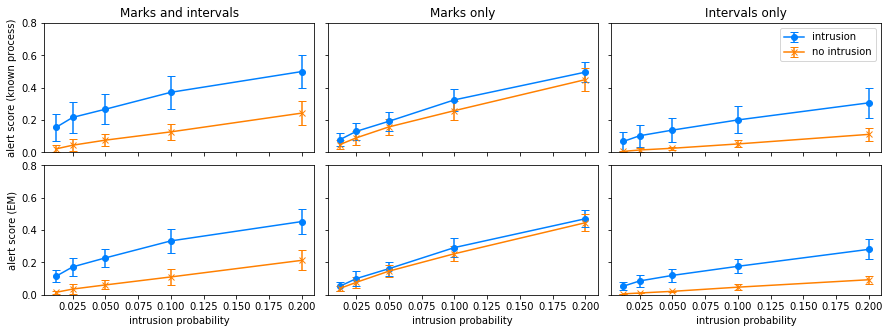

In [196]:
f_s_aas, sps = plt.subplots(2, 3, sharex=True, sharey=True)
f_s_aas.subplots_adjust(hspace=0.1, wspace=0.05)
f_s_aas.set_figwidth(15)
f_s_aas.set_figheight(5)
sps[0, 0].set_ylabel("alert score (known process)")
sps[1, 0].set_ylabel("alert score (EM)")
sps[0, 0].set_title("Marks and intervals")
sps[0, 1].set_title("Marks only")
sps[0, 2].set_title("Intervals only")
for j, mask in enumerate(["", "F", "G"]):
    sps[1, j].set_xlabel("intrusion probability")
    for i in range(2):
        sps[i, j].set_ylim(0, 0.8)
    for (i, em) in enumerate(["False", "True"]):
        ys = numpy.array([curves[em + mask][p] for p in ps])
        sps[i, j].errorbar(xs, ys[:, 0], yerr=ys[:, 2], marker='o', capsize=4, label="intrusion", color=[0, 0.5, 1])
        sps[i, j].errorbar(xs, ys[:, 1], yerr=ys[:, 3], marker='x', capsize=4, label="no intrusion", color=[1, 0.5, 0])
    handles, labels = sps[0, 2].get_legend_handles_labels()
sps[0, 2].legend(handles, labels)
# f_s_aas.savefig('../figures/synthetic-alert-score.pdf')

#### Fine-grained metrics

We also obtain more fine-grained metrics of detection accuracy. 

* AUC on total intrusion probability
* AUC on marginal event probabilities
* Jackard similarity for MAP

#### AUC

EM	mask	p	auc_MI	auc_M	auc_I
False		0.0125	0.7374	0.5777	0.7472
True	G	0.0125	0.6553	0.5423	0.6536
False	G	0.0250	0.7700	0.5902	0.7564
True	G	0.0250	0.6726	0.5117	0.6548
False	G	0.0500	0.7439	0.5449	0.7517
True	G	0.0500	0.6582	0.5007	0.6897
False	G	0.1000	0.7711	0.5827	0.7693
True	G	0.1000	0.6996	0.5411	0.6893
False	G	0.2000	0.7442	0.5643	0.7569
True	G	0.2000	0.6632	0.5237	0.7046


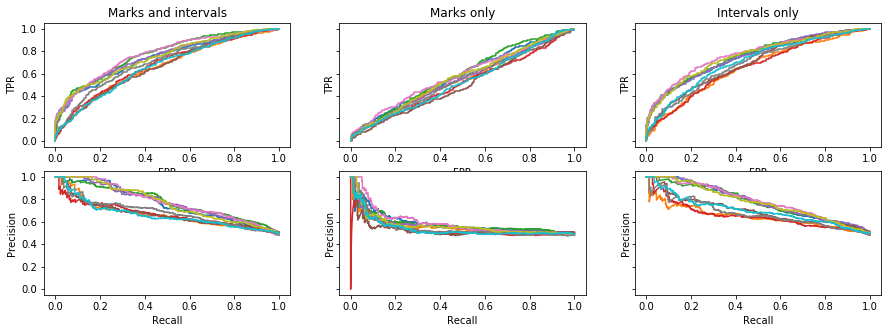

In [231]:
print("EM\tmask\tp\tauc_MI\tauc_M\tauc_I")
pcurves = {}
f, sp = plt.subplots(2, 3, sharey=True)
f.set_figwidth(15)
f.set_figheight(5)
sp[0, 0].set_title("Marks and intervals")
sp[0, 1].set_title("Marks only")
sp[0, 2].set_title("Intervals only")
for j in range(3):
    sp[0, j].set_xlabel("FPR")
    sp[0, j].set_ylabel("TPR")
    sp[1, j].set_xlabel("Recall")
    sp[1, j].set_ylabel("Precision")
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{}\t{:.4f}"
                  .format(EM, mask, ds["p"]), end="")
        for j, mask in enumerate(["", "F", "G"]):
            key = str(EM) + mask
            fpr, tpr, thresholds = metrics.roc_curve(ds["Z"].sum(axis=1) > 0,
                                                     ds["P" + key], 
                                                     pos_label=True)
            precision, recall, thresholds = metrics.precision_recall_curve(
                                                     ds["Z"].sum(axis=1) > 0,
                                                     ds["P" + key],
                                                     pos_label=True)
            sp[0, j].plot(fpr, tpr)
            sp[1, j].plot(recall, precision)
            auc = metrics.auc(fpr, tpr)
            if key not in pcurves:
                pcurves[key] = {}
            pcurves[key][ds["p"]] = auc
            print("\t{:.4f}".format( auc), end="")
        print()

Let's visualize AUC:

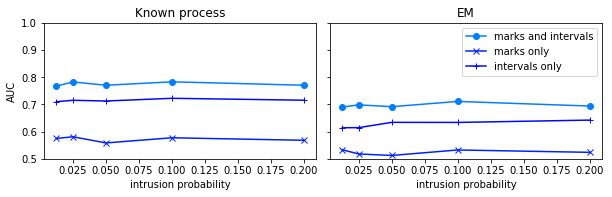

In [232]:
xs = ps
f_s_pauc, sps = plt.subplots(1, 2, sharex=True, sharey=True)
f_s_pauc.subplots_adjust(wspace=0.05, hspace=0.05)
f_s_pauc.set_figwidth(10)
f_s_pauc.set_figheight(2.5)
sps[0].set_title("Known process")
sps[1].set_title("EM")
sps[0].set_ylabel("AUC")
for i in range(2):
    sps[i].set_ylim(0.5, 1.)
    sps[i].set_xlabel("intrusion probability")
for j, (label, mask) in enumerate([("marks and intervals", ""), ("marks only", "F"), ("intervals only", "G")]):
    for (i, em) in enumerate(["False", "True"]):
        ys = numpy.array([pcurves[em + mask][p] for p in ps])
        sps[i].plot(xs, ys, label=label, marker=['o', 'x', '+'][j], color = [x**(2*j + 1) for x in [0, 0.5, 1]])
    handles, labels = sps[1].get_legend_handles_labels()
sps[1].legend(handles, labels)
# f_s_pauc.savefig("../figures/synthetic-auc-per-entry.pdf")

#### AUC of individual events

EM	mask	p	auc_MI	auc_M	auc_I
False		0.0125	0.8807	0.6821	0.8653
True	G	0.0125	0.8632	0.6831	0.8452
False	G	0.0250	0.8741	0.6736	0.8603
True	G	0.0250	0.8562	0.6684	0.8442
False	G	0.0500	0.8753	0.6708	0.8628
True	G	0.0500	0.8578	0.6700	0.8462
False	G	0.1000	0.8827	0.6705	0.8667
True	G	0.1000	0.8615	0.6699	0.8505
False	G	0.2000	0.8694	0.6542	0.8658
True	G	0.2000	0.8498	0.6519	0.8499


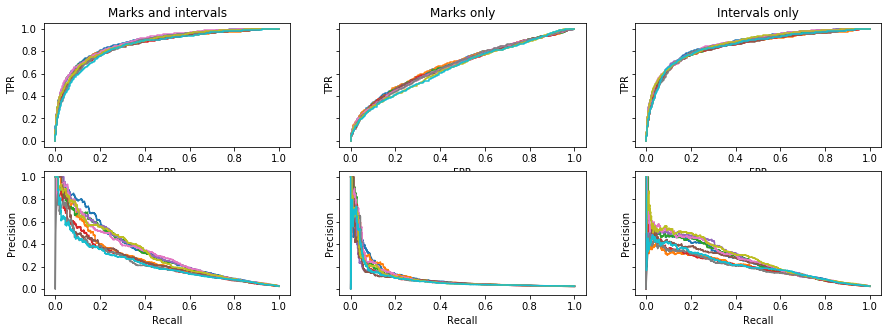

In [213]:
print("EM\tmask\tp\tauc_MI\tauc_M\tauc_I")
lcurves = {}
f, sp = plt.subplots(2, 3, sharey=True)
f.set_figwidth(15)
f.set_figheight(5)
sp[0, 0].set_title("Marks and intervals")
sp[0, 1].set_title("Marks only")
sp[0, 2].set_title("Intervals only")
for j in range(3):
    sp[0, j].set_xlabel("FPR")
    sp[0, j].set_ylabel("TPR")
    sp[1, j].set_xlabel("Recall")
    sp[1, j].set_ylabel("Precision")
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{}\t{:.4f}"
                  .format(EM, mask, ds["p"]), end="")
        for j, mask in enumerate(["", "F", "G"]):
            key = str(EM) + mask
            fpr, tpr, thresholds = metrics.roc_curve(ds["Z"].reshape((-1, 1)) > 0,
                                                     ds["M" + key].reshape((-1, 1)), 
                                                     pos_label=True)
            precision, recall, thresholds = metrics.precision_recall_curve(
                                                     ds["Z"].reshape((-1, 1)) > 0,
                                                     ds["M" + key].reshape((-1, 1)),
                                                     pos_label=True)
            sp[0, j].plot(fpr, tpr)
            sp[1, j].plot(recall, precision)
            auc = metrics.auc(fpr, tpr)
            if key not in lcurves:
                lcurves[key] = {}
            lcurves[key][ds["p"]] = auc
            print("\t{:.4f}".format( auc), end="")
        print()

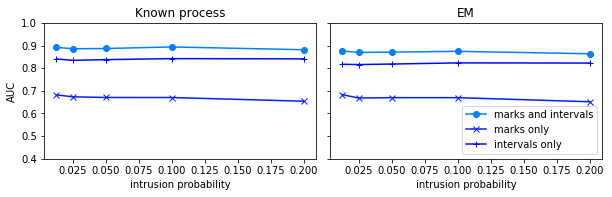

In [226]:
xs = ps
f_s_mauc, sps = plt.subplots(1, 2, sharex=True, sharey=True)
f_s_mauc.subplots_adjust(wspace=0.05, hspace=0.05)
f_s_mauc.set_figwidth(10)
f_s_mauc.set_figheight(2.5)
sps[0].set_title("Known process")
sps[1].set_title("EM")
sps[0].set_ylabel("AUC")
for i in range(2):
    sps[i].set_ylim(0.4, 1.)
    sps[i].set_xlabel("intrusion probability")
for j, (label, mask) in enumerate([("marks and intervals", ""), ("marks only", "F"), ("intervals only", "G")]):
    for (i, em) in enumerate(["False", "True"]):
        ys = numpy.array([lcurves[em + mask][p] for p in ps])
        sps[i].plot(xs, ys, label=label, marker=['o', 'x', '+'][j], color = [x**(2*j + 1) for x in [0, 0.5, 1]])
    handles, labels = sps[1].get_legend_handles_labels()
sps[1].legend(handles, labels, loc="lower right")
# f_s_mauc.savefig("../figures/synthetic-auc-per-entry.pdf")

#### Jaccard similarity

In [236]:
print("EM\tp\tjss_MI\tjss_M\tjss_I")
jcurves = {}
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{:.4f}".format(EM, ds["p"]), end="")
        for mask in ["", "F", "G"]:
            key = str(EM) + mask
            jss = metrics.jaccard_similarity_score(ds["Z"], ds["L" + key])
            if key not in jcurves:
                jcurves[key] = {}
            jcurves[key][ds["p"]] = jss
            print("\t{:.4f}".format(jss), end="")
        print()

EM	p	jss_MI	jss_M	jss_I
False	0.0125	0.5470	0.5080	0.5080
True	0.0125	0.5100	0.5080	0.5060
False	0.0250	0.5600	0.5190	0.5240
True	0.0250	0.5200	0.5170	0.5140
False	0.0500	0.5500	0.4960	0.5125
True	0.0500	0.5090	0.4970	0.4960
False	0.1000	0.5827	0.5250	0.5530
True	0.1000	0.5385	0.5290	0.5235
False	0.2000	0.5808	0.4827	0.5423
True	0.2000	0.5263	0.4952	0.5183


Let's visualize Jaccard score:

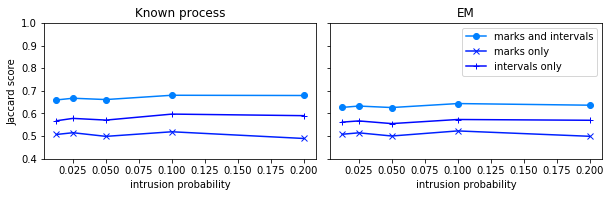

In [250]:
xs = ps
f_s_jss, sps = plt.subplots(1, 2, sharex=True, sharey=True)
f_s_jss.subplots_adjust(wspace=0.05, hspace=0.05)
f_s_jss.set_figwidth(10)
f_s_jss.set_figheight(2.5)
sps[0].set_title("Known process")
sps[1].set_title("EM")
sps[0].set_ylabel("Jaccard score")
for i in range(2):
    sps[i].set_ylim(0.4, 1.)
    sps[i].set_xlabel("intrusion probability")
for j, (label, mask) in enumerate([("marks and intervals", ""), ("marks only", "F"), ("intervals only", "G")]):
    for (i, em) in enumerate(["False", "True"]):
        ys = numpy.array([jcurves[em + mask][p] for p in ps])
        sps[i].plot(xs, ys, label=label, marker=['o', 'x', '+'][j], color = [x**(2*j + 1) for x in [0, 0.5, 1]])
    handles, labels = sps[1].get_legend_handles_labels()
sps[1].legend(handles, labels)
# f_s_jss.savefig("../figures/synthetic-jaccard-score.pdf")

## Evaluation on anonymized real-world data

In [20]:
def cfname(t, intr):
    return format("../data/{}-collected-{}.npy".format(t, intr))

The dataset as given is split into positive and negative samples. We load the dataset and concatenate both parts.

In [254]:
Ss = []
Zs = []
for intr in ["negative", "positive"]:
    Ss.append(numpy.load(cfname("s", intr)))
    Zs.append(numpy.load(cfname("z", intr)))
ds = {}
ds["S"] = numpy.concatenate(Ss, axis=0)
ds["Z"] = numpy.concatenate(Zs, axis=0)
ds["T"] = numpy.array([[0., 1.]] * ds["S"].shape[0])
assert ds["S"].shape[0] == ds["Z"].shape[0]

We shuffle samples in the data set and split it into the training and testing data set. We will use the training dataset to estimate prior probability of intrusion.

In [260]:
NSAMPLES, N, _ = ds["S"].shape
TRAIN_FRACTION = 5

indices = numpy.array(range(NSAMPLES))
numpy.random.shuffle(indices)

ds["S"] = ds["S"][indices]
ds["Z"] = ds["Z"][indices]

print("{} samples, {} time points per sample".format(NSAMPLES, N))

train_indices = indices[:len(indices) // TRAIN_FRACTION]
test_indices = indices[len(indices) // TRAIN_FRACTION:]

ds_train = {}
ds_test = {}
for key in ["S", "Z", "T"]:
    ds_train[key] = ds[key][train_indices]
    ds_test[key] = ds[key][test_indices]

1000 samples, 50 time points per sample


In [ ]:
ps = [0.05, 0.1, 0.2, 0.4, 0.8]
print("p\tpauc\tmauc\tjss")
f, plot = plt.subplots(1, 1)
plot.set_xlabel("FPR")
plot.set_ylabel("TPR")
maxauc = 0.
pbest = 0.
for p in ps:
    ds_train["p"] = p
    posteriors(ds_train, EM=True, F=None, G=None)
    fpr, tpr, thresholds = metrics.roc_curve(ds_train["Z"].sum(axis=1) > 0,
                                             ds_train["PTrue"], 
                                             pos_label=True)
    pauc = metrics.auc(fpr, tpr)
    plot.plot(fpr, tpr, c='blue', label='per entry')

    fpr, tpr, thresholds = metrics.roc_curve(ds_train["Z"].reshape(-1) > 0,
                                             ds_train["MTrue"].reshape(-1), 
                                             pos_label=True)
    mauc = metrics.auc(fpr, tpr)
    plot.plot(fpr, tpr, c='orange', label='per event')

    jss = metrics.jaccard_similarity_score(ds_train["Z"], ds_train["LTrue"])

    print("{:.4f}\t{:.4f}\t{:.4f}\t{:4f}".format(p, pauc, mauc, jss))
    
    if mauc*pauc > maxauc:
        pbest = p
        maxauc = mauc*pauc
 
print("pbest = {:.4f}".format(pbest))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles[-2:], labels[-2:])

We chose $p$, the prior intrusion probability, to maximize the AUC. With $p$ chosen, we  evaluate the algorithm on the test dataset. 

In [326]:
ds_test["p"] = pbest
posteriors(ds_test, EM=True, F=None, G=None)

          AUC per entry    AUC per event    Jaccard score  
MI            0.7103           0.9098           0.5837     
M             0.5818           0.7562           0.5242     
I             0.6825           0.8737           0.5143     


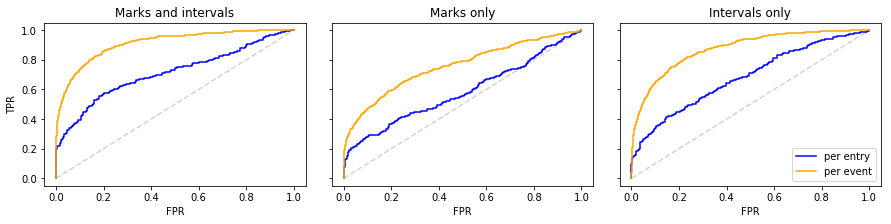

In [341]:
f_a_roc, sps = plt.subplots(1, 3, sharey=True)
f_a_roc.set_figheight(3)
f_a_roc.set_figwidth(15)
f_a_roc.subplots_adjust(wspace=0.1)
sps[0].set_ylabel("TPR")
sps[0].set_title("Marks and intervals")
sps[1].set_title("Marks only")
sps[2].set_title("Intervals only")
print(("{:8s}" + "".join([" {:^16s}"] * 3))
      .format("", "AUC per entry", "AUC per event", "Jaccard score"))
for i, (mask, label) in enumerate([("", "MI"), ("F", "M"), ("G", "I")]):
    sps[i].set_xlabel("FPR")

    fpr, tpr, thresholds = metrics.roc_curve(ds_test["Z"].sum(axis=1) > 0,
                                             ds_test["PTrue" + mask], 
                                             pos_label=True)
    pauc = metrics.auc(fpr, tpr)
    sps[i].plot(fpr, fpr, '--', c='lightgray')
    sps[i].plot(fpr, tpr, c='blue', label='per entry')

    fpr, tpr, thresholds = metrics.roc_curve(ds_test["Z"].reshape(-1) > 0,
                                             ds_test["MTrue" + mask].reshape(-1), 
                                             pos_label=True)
    mauc = metrics.auc(fpr, tpr)
    sps[i].plot(fpr, tpr, c='orange', label='per event')

    jss = metrics.jaccard_similarity_score(ds_test["Z"], ds_test["LTrue" + mask])

    print(("{:8s}" + "".join([" {:^16.4f}"] * 3))
          .format(label, pauc, mauc, jss))
sps[2].legend()
f_a_roc.savefig("../figures/anonymized-roc.pdf")